In [3]:
import pandas as pd
import json
import os
import datetime as dt

# Preprocessing
##### this file contains code which is not modular and reason for this is that I want you to
##### follow every step of preprocessing with immediate results
##### there is EDA at the end

In [7]:
FILE_FIRE_DATA = 'Seattle_Real_Time_Fire_911_Calls.csv'
FILE_WEATHER_DATA = 'Seattle Weatherdata 2002 to 2020.csv'

# discarding columns which are not of more importance (hand picked)
# dropping Latitude and Longitude from fire data because weather data does not contain different lat and longs
fire_data_org = pd.read_csv(FILE_FIRE_DATA, parse_dates = ['Datetime'], usecols = ['Datetime'])
weather_data_org = pd.read_csv(FILE_WEATHER_DATA, usecols = ['dt_iso', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
       'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h', 'clouds_all'])




In [8]:
fire_data = fire_data_org.copy(deep=True)
weather_data = weather_data_org.copy(deep=True)

# most of the seasonal data (rain, wind, snow etc) contains empty values, but it is of use
# therefore empty/null values can be replaced with 0
weather_data=weather_data.fillna(0)

In [9]:
# format datetime to make it standard
# in case of fire_data we want to use hourly information and discard information on minutes level
fire_data['Datetime'] = fire_data['Datetime'].dt.strftime('%Y-%m-%d %H')

# remove extra UTC info
weather_data['dt_iso'] = weather_data['dt_iso'].str.replace('\+0000 UTC', '')
# convert to datetime object and format
weather_data['dt_iso'] = pd.to_datetime(weather_data['dt_iso'])
weather_data['dt_iso'] = weather_data['dt_iso'].dt.strftime('%Y-%m-%d %H')

In [10]:
# weather data is not updated and contains values till date 2020-11-05 00
# therefore for simplicity I will use test year as 2019 and last five years starting from 2014 as train

weather_data=weather_data[(weather_data['dt_iso']>='2014-01-01') & (weather_data['dt_iso']<'2020-01-01')]
fire_data=fire_data[(fire_data['Datetime']>='2014-01-01') & (fire_data['Datetime']<'2020-01-01')] 

In [11]:
# Group hourly data to get the count of calls per hour which will be our target feature
# we can say that we are transforming data into supervised learning problem
fire_data = pd.DataFrame(fire_data.groupby('Datetime')['Datetime'].count()).rename(columns = {'Datetime':'calls'}).reset_index()

 # weather data contains duplicate values
weather_data = weather_data.drop_duplicates()

In [12]:
# len of fire_data is < weather_data because it is not mandatory that every hour contains emergency calls
print(len(fire_data))
print(len(weather_data))

52456
52584


In [173]:
##checking if weather data contains each and every hour of every day in the time period by comparing length
##here used 
#date_rng = pd.DataFrame(pd.date_range(start='1/1/2014', end='31/12/2019', freq='H'))
#date_rng.rename(columns={0:'Time'}, inplace=True)

# Left-join of weather_data and fire_data in order to get complete features (whole data)
joined_data = weather_data.merge(fire_data, how='left', left_on='dt_iso', right_on='Datetime')
# filling null values with zeros
joined_data=joined_data.fillna(0)


#### Now data is in proper form (hourly) having no null values

In [174]:
joined_data.drop(columns=['Datetime'], inplace=True)
joined_data = joined_data.sort_values(by='dt_iso')
joined_data

,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,calls
0,2014-01-01 00,7.03,1026,87,1.14,195,0.00,0.0,0.0,0.0,90,35.0
1,2014-01-01 01,6.66,1026,87,1.54,330,0.00,0.0,0.0,0.0,90,23.0
2,2014-01-01 02,6.28,1027,95,0.08,181,0.25,0.0,0.0,0.0,100,24.0
3,2014-01-01 03,5.92,1027,97,0.51,212,0.00,0.0,0.0,0.0,100,15.0
4,2014-01-01 04,5.87,1027,81,0.66,62,0.00,0.0,0.0,0.0,40,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
52579,2019-12-31 19,9.04,1012,79,10.30,170,0.25,0.0,0.0,0.0,100,14.0
52580,2019-12-31 20,8.80,1012,82,4.10,190,0.73,0.0,0.0,0.0,100,16.0
52581,2019-12-31 21,8.79,1010,94,2.24,169,0.25,0.0,0.0,0.0,100,13.0
52582,2019-12-31 22,8.96,1009,82,6.70,190,0.25,0.0,0.0,0.0,100,12.0


# Feature Engineering

#### datetime is of more importance and it makes sense to split

In [175]:
#splitting datetime column into multiple column so that data information at individual level can be processed
#by model
joined_data['dt_iso'] = pd.to_datetime(joined_data['dt_iso'])
joined_data['hour'] = joined_data['dt_iso'].dt.hour
joined_data['dayofweek'] = joined_data['dt_iso'].dt.dayofweek
joined_data['month'] = joined_data['dt_iso'].dt.month
joined_data['year'] = joined_data['dt_iso'].dt.year
joined_data['dayofyear'] = joined_data['dt_iso'].dt.dayofyear
joined_data['dayofmonth'] = joined_data['dt_iso'].dt.day
joined_data.drop(columns=['dt_iso'],inplace=True)

In [176]:
# splitting into train and test data
# train_data consists of data from year 2014 to 2018
train_data = joined_data[joined_data['year']<2019]
# test_data consists of year 2019
test_data = joined_data[joined_data['year']==2019]

In [177]:
# add another colum which holds the number of calls of previous point in time (hour)
train_data = train_data.assign(previous_hour_calls =  train_data['calls'].shift(1))
train_data = train_data.dropna()
# separate train_x and train_y
train_y = pd.DataFrame(train_data['calls'])
train_x = train_data.drop(columns = ['calls'])
#train_x

test_y = pd.DataFrame(test_data['calls'])
test_x = test_data.drop(columns = ['calls'])
test_x

,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,hour,dayofweek,month,year,dayofyear,dayofmonth
43824,4.45,1032,73,2.60,310,0.00,0.0,0.00,0.0,27,0,1,1,2019,1,1
43825,3.40,1032,73,2.60,320,0.00,0.0,0.00,0.0,12,1,1,1,2019,1,1
43826,2.53,1032,81,1.35,41,0.00,0.0,0.00,0.0,40,2,1,1,2019,1,1
43827,2.10,1031,80,0.91,50,0.00,0.0,0.00,0.0,1,3,1,1,2019,1,1
43828,1.63,1031,86,0.52,359,0.00,0.0,0.25,0.0,40,4,1,1,2019,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,9.04,1012,79,10.30,170,0.25,0.0,0.00,0.0,100,19,1,12,2019,365,31
52580,8.80,1012,82,4.10,190,0.73,0.0,0.00,0.0,100,20,1,12,2019,365,31
52581,8.79,1010,94,2.24,169,0.25,0.0,0.00,0.0,100,21,1,12,2019,365,31
52582,8.96,1009,82,6.70,190,0.25,0.0,0.00,0.0,100,22,1,12,2019,365,31


# Model building

In [34]:
import xgboost as xgb
import sklearn
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators = 1000)

In [36]:
model.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [135]:
import tqdm

## as I used previous_hour_calls as one of the feature, therefore prediction will be in
## sequential manner. For the first test example we used number of calls from the last training example and later
## get prediction for first test sample and used this values as a feature for getting prediction of the next
## test sample and so on.
def make_predict(test_x, test_y, train_y, model):
    predictions = []
    originals = []
    pred = int(train_y.iloc[-1].values)
    for i in tqdm.tqdm(range(len(test_x))):
        x = test_x[i:i+1]
        x = x.assign(previous_hour_calls = pred)
        y = test_y[i:i+1]
        pred = model.predict(x)
        predictions.append(pred[0])
        originals.append(int(y.values))
        #print(round(pred[0]))
        #print(int(y.values))
        #return 0
    return predictions, originals


In [136]:
preds, y = make_predict(test_x, test_y, train_y, model)

100%|██████████| 8760/8760 [05:10<00:00, 28.19it/s]


In [142]:
## calculating RMSE
print(mean_squared_error(y, preds, squared=False))

4.078223317004002


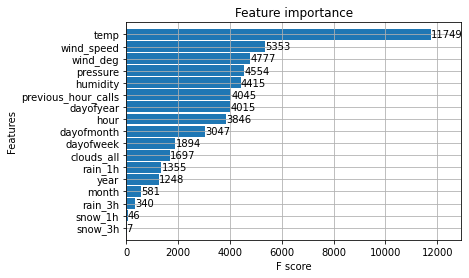

In [179]:
## plotting the importance of features
_ = plot_importance(model, height=0.9)

27.383894076072


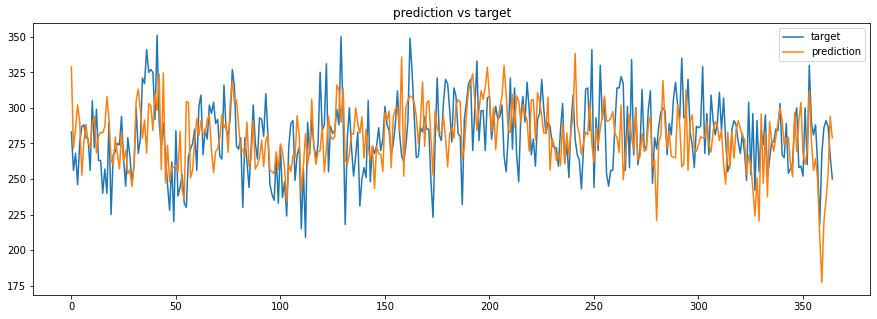

In [155]:
from matplotlib import pyplot
## Plotting around 8k samples is not going to be useful visually
## We can plot results of each day instead of the hours

preds_day = np.add.reduceat(preds, np.arange(0, len(preds), 24))
y_day = np.add.reduceat(y, np.arange(0, len(y), 24))

pyplot.figure(figsize=(15,5))
pyplot.title("prediction vs target")
pyplot.plot(y_day, label='target')
pyplot.plot(preds_day, label='prediction')
pyplot.legend()

## print RMSE
print(mean_squared_error(y_day, preds_day, squared=False))